In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
import folium
from folium import plugins
import contextily as cx
from folium.plugins import MarkerCluster
import os
import json
import requests

In [2]:
data = pd.read_csv("AIS_2022_03_31.csv")

In [3]:
data.head(5)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,367702220,2022-03-31T00:00:01,29.78763,-95.08070,0.1,226.5,340.0,JOE B WARD,NaN,WDI4808,31.0,12.0,21.0,8.0,NaN,57.0,A
1,671226100,2022-03-31T00:00:01,25.77626,-80.20320,3.2,143.7,511.0,RELIANCE II,IMO9221322,5VHS7,79.0,0.0,52.0,12.0,2.5,70.0,A
2,367767250,2022-03-31T00:00:01,29.31623,-94.78829,4.5,228.1,511.0,GLEN K,NaN,WDJ3358,52.0,0.0,0.0,0.0,0.0,52.0,A
3,338327436,2022-03-31T00:00:03,47.29634,-122.42233,0.0,360.0,511.0,COOL KAT,IMO0000000,NaN,36.0,NaN,15.0,3.0,NaN,NaN,B
4,367452810,2022-03-31T00:00:06,29.32824,-94.77391,2.6,319.2,511.0,JOHN W JOHNSON,IMO9602344,WDF4516,60.0,0.0,80.0,19.0,3.0,60.0,A


In [4]:
geometry = gpd.points_from_xy(data.LON, data.LAT, crs="EPSG:4326")

In [5]:
gdf = gpd.GeoDataFrame(data, geometry=geometry)

In [6]:
gdf

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,geometry
0,367702220,2022-03-31T00:00:01,29.78763,-95.08070,0.1,226.5,340.0,JOE B WARD,NaN,WDI4808,31.0,12.0,21.0,8.0,NaN,57.0,A,POINT (-95.08070 29.78763)
1,671226100,2022-03-31T00:00:01,25.77626,-80.20320,3.2,143.7,511.0,RELIANCE II,IMO9221322,5VHS7,79.0,0.0,52.0,12.0,2.5,70.0,A,POINT (-80.20320 25.77626)
2,367767250,2022-03-31T00:00:01,29.31623,-94.78829,4.5,228.1,511.0,GLEN K,NaN,WDJ3358,52.0,0.0,0.0,0.0,0.0,52.0,A,POINT (-94.78829 29.31623)
3,338327436,2022-03-31T00:00:03,47.29634,-122.42233,0.0,360.0,511.0,COOL KAT,IMO0000000,NaN,36.0,NaN,15.0,3.0,NaN,NaN,B,POINT (-122.42233 47.29634)
4,367452810,2022-03-31T00:00:06,29.32824,-94.77391,2.6,319.2,511.0,JOHN W JOHNSON,IMO9602344,WDF4516,60.0,0.0,80.0,19.0,3.0,60.0,A,POINT (-94.77391 29.32824)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167041,636018637,2022-03-31T00:22:46,12.52147,141.68964,13.4,324.3,327.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A,POINT (141.68964 12.52147)
7167042,370101000,2022-03-31T08:37:49,10.91870,142.85554,13.5,330.4,330.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A,POINT (142.85554 10.91870)
7167043,370101000,2022-03-31T09:48:29,11.14859,142.71331,13.5,325.2,329.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A,POINT (142.71331 11.14859)
7167044,370101000,2022-03-31T19:15:28,12.93339,141.57638,13.1,326.3,330.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A,POINT (141.57638 12.93339)


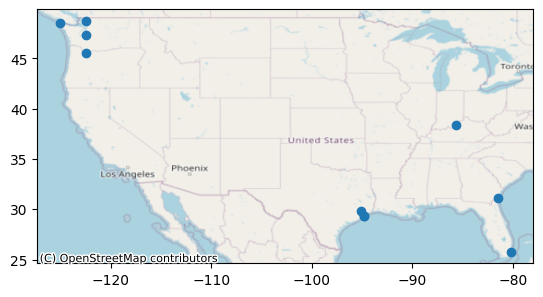

In [7]:
ax = gdf.head(10).plot()
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik)

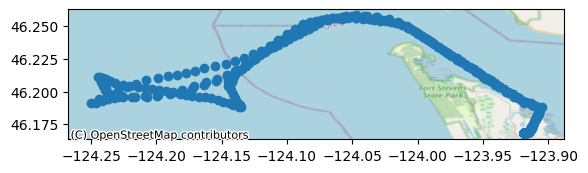

In [8]:
sample = gdf[gdf["MMSI"] == 367605150]
ax = sample.plot()
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik)

In [9]:
mmsis = [mmsi_num for mmsi_num in sample["MMSI"].unique()]
MMSI_list_for_popup = []
for mmsi in mmsis:
    MMSI_list_for_popup.append("MMSI:" + str(mmsi))

In [10]:
latlonlist = []
for lat, lon in zip(sample.LAT, sample.LON):
    latlonlist.append([lat, lon])

In [11]:
latlonlist[0]

[46.16837, -123.91853]

In [12]:
gdf_sample = gdf.head(100000)

mean_lat = gdf_sample.LAT.mean()
mean_lon = gdf_sample.LON.mean()

## Create the basic map
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=10, tiles = None)

## Add a basic OpenStreetMap (OSM) tile
folium.TileLayer(tiles = 'openstreetmap', name = "OSM BASIC").add_to(m)
## Add an OSM-Dark tile
folium.TileLayer(tiles = "https://cartodb-basemaps-{s}.global.ssl.fastly.net/dark_all/{z}/{x}/{y}.png",  
                 name="OSM DARK", attr="OpenStreetMap Dark | <a href=https://wiki.openstreetmap.org/wiki/Tile_servers</a>").add_to(m)
## Add another tile, but this time with ESRI-satellite imagery
folium.TileLayer(tiles = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", name = "ESRI Worldview", 
                 attr="Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community").add_to(m)

# folium.PolyLine(
#     locations=latlonlist,
#     color="#FF0000",
#     weight=5,
#     tooltip=MMSI_list_for_popup[0],
# ).add_to(m)

# for [lat, lon] in latlonlist:
#     folium.CircleMarker(
#     location=[lat, lon],
#     radius=2,
#     color="red",
#     weight=3,
#     fill=False,
#     fill_opacity=0.6,
#     opacity=1,
#     popup="MMSI:" + str(sample["MMSI"].unique()[0])
#     ).add_to(m)

marker_cluster = MarkerCluster().add_to(m)
 
for idx, row in gdf_sample.iterrows():
    folium.Marker(location=[row.geometry.y, row.geometry.x]).add_to(marker_cluster)

## Adding a button to control which map tile layer to use
folium.LayerControl().add_to(m)

## Adding a method to draw polygons on your map
draw = plugins.Draw(export=True)
draw.add_to(m)

measurement_control = plugins.MeasureControl()
measurement_control.add_to(m)  

m


KeyboardInterrupt



# OV-fietsen

In [13]:
fiets_locs = pd.read_csv("alle_locaties.csv", on_bad_lines='skip')

In [24]:
data = requests.get("http://fiets.openov.nl/locaties.json")

In [25]:
gdf = gpd.GeoDataFrame(data.json()["locaties"])
gdf = gdf.transpose()


In [16]:
n_ov_bikes_list = []
for idx, row in gdf.iterrows():
    if "rentalBikes" in row["extra"].keys():
        n_ov_bikes = row["extra"]["rentalBikes"]
        n_ov_bikes_list.append(n_ov_bikes)
    else:
        n_ov_bikes_list.append(0)

In [17]:
gdf["n_ov_bikes"] = n_ov_bikes_list

In [18]:
gdf.reset_index(inplace=True)

In [19]:
geometry = gpd.points_from_xy(gdf.lng, gdf.lat, crs="EPSG:4326")

In [20]:
gdf = gpd.GeoDataFrame(gdf, geometry=geometry)

In [21]:
gdf.to_csv("OV_FIETS_DATA.csv")

In [22]:
gdf

,index,infoImages,city,postalCode,name,extra,houseNumber,extraInfo,apps,sites,...,street,link,stationCode,openingHours,lng,open,thumbnail,description,n_ov_bikes,geometry
0,utt001,[{'body': 'U vindt de OV-fietskluizen in de fi...,Vleuten,3451 ST,UTT - OV-fiets - Utrecht Terwijde,"{'fetchTime': 1715682612, 'rentalBikes': '2', ...",1,[],[],[],...,Hof ter Weydeweg,{'uri': 'https://places.ns-mlab.nl/api/v2/plac...,UTT,"[{'dayOfWeek': 1, 'endTime': '24:00', 'closesN...",5.04424,Yes,"{'uri': '/api/v1/location/thumbnail/52.10017,5...",Utrecht Terwijde,2,POINT (5.04424 52.10017)
1,bmn001,[{'body': 'U vindt de OV-fietskluizen in de fi...,Brummen,6971 BX,BMN - OV-fiets - Brummen,"{'fetchTime': 1715682612, 'rentalBikes': '5', ...",,[],[],[],...,Stationsweg,{'uri': 'https://places.ns-mlab.nl/api/v2/plac...,BMN,"[{'dayOfWeek': 1, 'endTime': '24:00', 'closesN...",6.14726,Yes,"{'uri': '/api/v1/location/thumbnail/52.09104,6...",Brummen,5,POINT (6.14726 52.09104)
2,eml001,[{'body': 'Als u het perron afloopt en spoor 1...,Ermelo,3851 JB,EML - OV-fiets - Ermelo,"{'fetchTime': 1715682612, 'rentalBikes': '2', ...",46A,[],[],[],...,Dr van Dalenlaan,{'uri': 'https://places.ns-mlab.nl/api/v2/plac...,EML,NaN,5.61434,Unknown,"{'uri': '/api/v1/location/thumbnail/52.30039,5...",Ermelo,2,POINT (5.61434 52.30039)
3,Rvs001,[{'body': 'Je huurt hier een OV-fiets met het ...,Ravenstein,5371 BB,RVS - OV fiets - Ravenstein,"{'fetchTime': 1715682612, 'rentalBikes': '5', ...",122,[],[],[],...,Stationssingel,{'uri': 'https://places.ns-mlab.nl/api/v2/plac...,RVS,"[{'dayOfWeek': 1, 'endTime': '24:00', 'closesN...",5.637462,Yes,"{'uri': '/api/v1/location/thumbnail/51.79464,5...",Ravenstein,5,POINT (5.63746 51.79464)
4,UTVR001,[{'body': 'Als u de trap van het perron afloop...,Utrecht,3523 CA,UT-OV-fiets-Utrecht Vaartsche Rijn,"{'serviceType': 'Bemenst', 'rentalBikes': '6',...",103,[],[],[],...,Baden-Powellweg,{'uri': 'https://places.ns-mlab.nl/api/v2/plac...,UTVR,"[{'dayOfWeek': 1, 'endTime': '01:00', 'closesN...",5.122392,Yes,"{'uri': '/api/v1/location/thumbnail/52.078023,...",Utrecht Vaartsche Rijn Oosterkade,6,POINT (5.12239 52.07802)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,apd001,[{'body': 'Je huurt hier zelf een OV-fiets met...,Apeldoorn,7311 NZ,APD - OV-fiets - Apeldoorn,"{'serviceType': 'Bemenst', 'rentalBikes': '4',...",12,[],[],[],...,Stationsplein,{'uri': 'https://places.ns-mlab.nl/api/v2/plac...,APD,"[{'dayOfWeek': 1, 'endTime': '00:35', 'closesN...",5.9692,Yes,"{'uri': '/api/v1/location/thumbnail/52.209578,...",Apeldoorn,4,POINT (5.96920 52.20958)
286,hgl002,[{'body': 'Je huurt hier zelf een OV-fiets met...,Hengelo,7551 CN,HGL - OV-fiets - Hengelo,"{'fetchTime': 1715682612, 'rentalBikes': '2', ...",1,[],[],[],...,Stationsplein,{'uri': 'https://places.ns-mlab.nl/api/v2/plac...,HGL,"[{'dayOfWeek': 1, 'endTime': '01:25', 'closesN...",6.7936,Yes,"{'uri': '/api/v1/location/thumbnail/52.26239,6...",Hengelo,2,POINT (6.79360 52.26239)
287,rsw002,[{'body': 'Je huurt hier een OV-fiets met het ...,Rijswijk,2283 CK,RSW - OV-fiets - Rijswijk,"{'serviceType': 'Bemenst', 'rentalBikes': '19'...",9,[],[],[],...,Piramideplein,{'uri': 'https://places.ns-mlab.nl/api/v2/plac...,RSW,"[{'dayOfWeek': 1, 'endTime': '01:10', 'closesN...",4.31965,Yes,"{'uri': '/api/v1/location/thumbnail/52.03988,4...",Rijswijk,19,POINT (4.31965 52.03988)
288,mdb002,[{'body': 'Je huurt hier zelf een OV-fiets met...,Middelburg,4337 PA,MDB - OV-fiets - Middelburg,"{'fetchTime': 1715682612, 'rentalBikes': '20',...",22,[],[],[],...,Kanaalweg,{'uri': 'https://places.ns-mlab.nl/api/v2/plac...,MDB,"[{'dayOfWeek': 1, 'endTime': '01:20', 'closesN...",3.61768,Yes,"{'uri': '/api/v1/location/thumbnail/51.49517,3...",Middelburg,20,POINT (3.61768 51.49517)


In [23]:
mean_lat = gdf.lat.mean()
mean_lon = gdf.lng.mean()

## Create the basic map
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=7, tiles = None)

## Add a basic OpenStreetMap (OSM) tile
folium.TileLayer(tiles = 'openstreetmap', name = "OSM BASIC").add_to(m)
## Add an OSM-Dark tile
folium.TileLayer(tiles = "https://cartodb-basemaps-{s}.global.ssl.fastly.net/dark_all/{z}/{x}/{y}.png",  
                 name="OSM DARK", attr="OpenStreetMap Dark | <a href=https://wiki.openstreetmap.org/wiki/Tile_servers</a>").add_to(m)
## Add another tile, but this time with ESRI-satellite imagery
folium.TileLayer(tiles = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", name = "ESRI Worldview", 
                 attr="Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community").add_to(m)

marker_cluster = MarkerCluster().add_to(m)
 
for idx, row in gdf.iterrows():
    popup_text = f"<b>Station</b>: {row.description}<br><br><b>Aantal fietsen</b>: {row.n_ov_bikes}" 
    folium.Marker(location=[row.geometry.y, row.geometry.x], popup=popup_text).add_to(marker_cluster)

## Adding a button to control which map tile layer to use
folium.LayerControl().add_to(m)

## Adding a method to draw polygons on your map
draw = plugins.Draw(export=True)
draw.add_to(m)

measurement_control = plugins.MeasureControl()
measurement_control.add_to(m)  

m